In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
# global parameters (due to paper)
erosion_size = 7
morph_element = cv2.getStructuringElement(cv2.MORPH_RECT, (erosion_size, erosion_size),
                                          (erosion_size//2, erosion_size//2))

In [2]:

def get_dark_channel_image(img):
    img1 = np.min(img, axis=2)  # max of colors
    return cv2.erode(img1, morph_element)


def obtain_a(img, img_dark, num_channel):
    img_size = img.shape[0] * img.shape[1]
    ind1, ind2 = np.unravel_index(np.argsort(img_dark, axis=None), img_dark.shape)
    ind1 = ind1[0: img_size // 10]
    ind2 = ind2[0: img_size // 10]
    a = np.max(np.sum(img[ind1, ind2, :], axis=1)) / 3
    a = 150
    return a


def get_t1(img, a):
    img1 = np.copy(img).astype(np.float)
    img1 = img1 / a
    t1 = 1 - np.min(img1, axis=2)
    return t1


def get_t2(t1):     # phi(t1)
    marker2 = cv2.dilate(np.copy(t1), morph_element)
    marker = np.zeros(marker2.shape, dtype=np.uint8)
    mask = np.copy(t1)

    # reconstruct via erosion
    i = 0
    while not np.all(marker == marker2):
        marker = marker2
        marker2 = geodesic_erosion(marker, mask, i)
        i += 1
    return marker



def get_t3(t2):
    marker2 = cv2.erode(np.copy(t2), morph_element)
    marker = np.zeros(marker2.shape, dtype=np.uint8)
    mask = np.copy(t2)
    # reconstruct via erosion
    i = 0
    while not np.all(marker == marker2):
        marker = marker2
        marker2 = geodesic_dilation(marker, mask, i)
        i += 1
    return marker


def get_t3_prime(t1, t2, t3):
    r = (np.max(t1) - np.min(t1)) / (np.max(t3) - np.min(t3))
    return t3 - r * np.min(t3) + np.min(t1)


def dehaze(img1, a, t_morph):
    # img1 = img1.astype(np.float)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2LUV)
    img2 = img1[:, :, 0].astype(np.float)

    t_morph[np.where(t_morph < 0.1)] = 0.1  # specify minimum t_morph
    t_morph = t_morph - np.min(t_morph)
    t_morph = t_morph / np.max(t_morph)
    t_morph = (t_morph * 0.8) + 0.2
    img2 = (img2 - a * (1 - t_morph)) / t_morph
    img2[np.where(img2 < 1)] = 0
    img2[np.where(img2 > 255)] = 255
    img2 = img2.astype(np.uint8)
    img1[:, :, 0] = img2
    img1 = cv2.cvtColor(img1, cv2.COLOR_LUV2RGB)
    return img1


def geodesic_erosion(marker, mask, n):
    marker = cv2.erode(marker, morph_element, iterations=n)
    img2 = np.array([marker, mask])
    return np.max(img2, axis=0)


def geodesic_dilation(marker, mask, n):
    marker = cv2.dilate(marker, morph_element, iterations=n)
    img2 = np.array([marker, mask])
    return np.min(img2, axis=0)

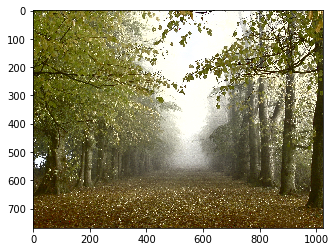

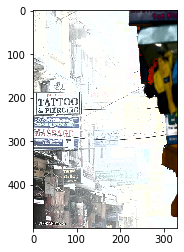

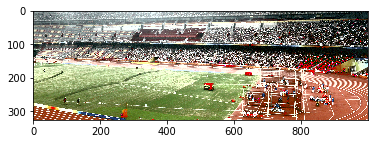

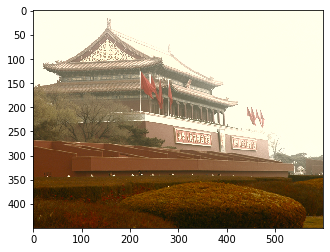

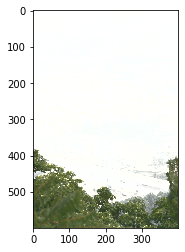

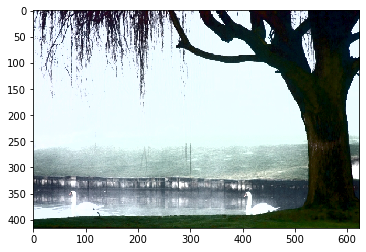

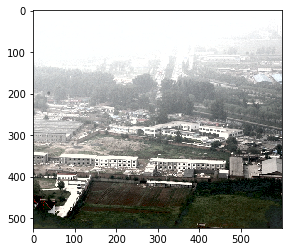

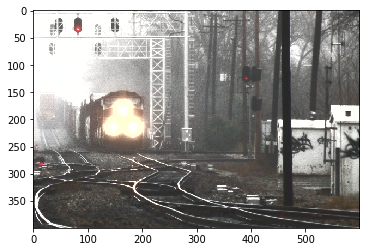

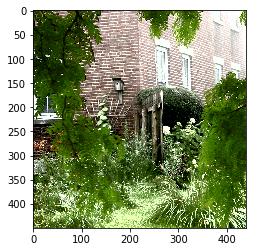

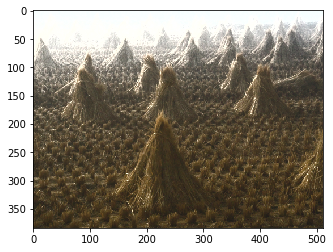

-1

In [12]:
for index in range(1, 11):
    img1 = cv2.imread("C:/Users/sherw/OneDrive/Desktop/DIP_Project/Final_project_code/dataset/haze/{}.png".format(index))
    # cv2.imshow("img1", img1)
    img_dark = get_dark_channel_image(img1)
    a = obtain_a(img1, img_dark, num_channel=3)
    t1 = get_t1(img1, a)
    t2 = get_t2(t1)
    t3 = get_t3(t2)
    r = t1 - t3
    t3_prime = get_t3_prime(t1, t2, t3)
    t_morph = t3_prime + r
    # cv2.imshow("t_morph", t_morph)
    img_dehazed = dehaze(img1, a, t_morph)
    # cv2.imshow("img_dehazed", img_dehazed)
    cv2.imwrite("img_dehazed_{}.png".format(index), img_dehazed)
    temp = cv2.cvtColor(img_dehazed, cv2.COLOR_BGR2RGB)
    plt.imshow(temp)
    plt.show()
cv2.waitKey()